<a href="https://colab.research.google.com/github/fanurs/pytorch-notes/blob/main/notes/tut04_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main reason for having automatic differentiation (AD) in PyTorch is to perform gradient descent (GD). In this tutorial, we will look at how optimization can be performed iteratively. This is exactly the same piece of mathematics used for "training" an artificial neural network (ANN).

# Gradient descent (GD)

As always, we learn from examples.

In [1]:
import matplotlib.pyplot as plt
import torch as th

Consider a two-variable function,
$$ f(x_0, x_1) = x_0\sin(x_0^2) + 2x_1\sin(x_1^2) \ . $$
Our goal is to minimize $f$ over the rectangular domain
$$ \mathcal{D} \equiv \{(x_0, x_1) : x_0\in[0, 3] \ \wedge \ x_1\in[0, 3] \} \ . $$

Here is a contour plot of the function:

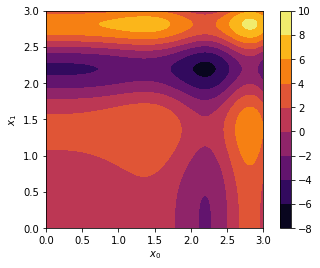

In [2]:
def surface(x0, x1):
    return x0 * th.sin(x0**2) + 2 * x1 * th.sin(x1**2)
xx = th.linspace(0, 3, 300)
yy = th.linspace(0, 3, 300)
xx, yy = th.meshgrid(xx, yy, indexing='ij')
zz = surface(xx, yy)
cb = plt.contourf(xx, yy, zz, cmap=plt.cm.inferno)
plt.colorbar(cb)
plt.gca().set_aspect('equal')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.show()

It is not hard to see that the lowest point over $\mathcal{D}$ is somewhere around $x_0 \approx 2.2$ and $x_1 \approx 2.2$. But how can we use gradient descent to find that?

The idea of gradient descent is pretty straightforward. First, we pick an initial point. The choice of the initial point is usually very crucial, but for now let us simply start with the center point of $\mathcal{D}$,
$$ \mathbf{x}_0 \equiv \begin{bmatrix}1.5\\1.5\end{bmatrix} \ . $$
Next, we evaluate the gradient at $\mathbf{x}_0$. From [basic calculus](http://aleph0.clarku.edu/~djoyce/ma131/directional.pdf), we know that $\nabla f(\mathbf{x}_0)$ gives the steepest ascent, and hence $-\nabla f(\mathbf{x}_0)$ gives the steepest descent. Since our goal is to minimize $f$, we naturally want to step toward the direction of steepest descent. This gives us
$$ \mathbf{x}_1 = \mathbf{x}_0 - \gamma\cdot\nabla f(\mathbf{x}_0) \ , $$
such that
$$ f(\mathbf{x}_1) \le f(\mathbf{x}_0) \ . $$
Here, $\gamma > 0$ is called the "learning rate" in machine learning. Typically, the value of $\gamma$ is smaller than one. The role of a learning rate is such that we can control the "step" size from $\mathbf{x}_0$ to $\mathbf{x}_1$. If the learning rate is too small, $\mathbf{x}_1$ and $\mathbf{x}_0$ would be very close to each other, and $f$ would have barely decreased, resulting in slower minimization process. On the other hand, if the learning rate is too large, we might have step over the minimum point between $\mathbf{x}_0$ and $\mathbf{x}_1$, and could result in $f(\mathbf{x}_1) > f(\mathbf{x}_0)$. In practice, learning rate $\gamma$ is determined empirically. A good value to start with is $\gamma = 0.01$.

To perform gradient descent, we simply repeat the above procedure as many times as needed according to
$$ \mathbf{x}_{n+1} = \mathbf{x}_n - \gamma\cdot\nabla f(\mathbf{x}_n) \ , $$
where $n = 0, 1, \ldots$.

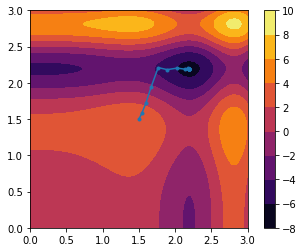

In [4]:
x_init = [1.5, 1.5]
x = th.tensor(x_init, requires_grad=True)
optimizer = th.optim.SGD([x], lr=0.02)

trace, grads = [th.clone(x.detach())], []
for _ in range(20):
    y = surface(*x)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    trace.append(th.clone(x.detach()))
    grads.append(th.clone(x.grad.detach()))
trace, grads = map(th.stack, (trace, grads))

plt.plot(trace[:, 0], trace[:, 1], '.-')
cb = plt.contourf(xx, yy, zz, cmap=plt.cm.inferno)
plt.colorbar(cb)
plt.gca().set_aspect('equal')
plt.show()

# Least square regression

Consider a quadratic model:
$$ f(x; p_0, p_1, p_2) = p_0 + p_1 x + p_2 x^2 \ . $$
We are given $n$ pairs of $(x_i, y_i)$ data. The goal is to fit $f$ to $(x_i, y_i)$ using least squares method. Mathematically, we define a loss function,
$$ \mathcal{L}(p_0, p_1, p_2) \equiv \sum_{i=1}^n \left[y_i - f(x_i; p_0, p_1, p_2)\right]^2 \ , $$
which depends on $p_0, p_1, p_2$. We want to find the values for $p_0, p_1, p_2$ such that $\mathcal{L}$ is the smallest over the domain of interest $\mathcal{D}$.

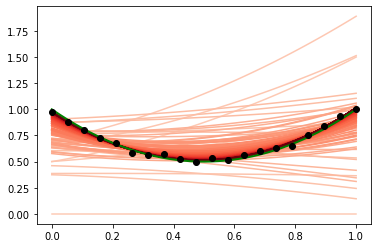

In [ ]:
model = lambda x, p0, p1, p2: p0 + p1 * x + p2 * x**2
rand_gen = th.Generator()
rand_gen.manual_seed(0)
x = th.linspace(0, 1, 20)
y = th.normal(model(x, 1, -2, 2), 0.02, generator=rand_gen) # real model

param = th.tensor([0.0, 0.0, 0.0], requires_grad=True)
optimizer = th.optim.Adam([param], lr=0.5)
x_plt = th.linspace(0, 1, 100)
n_iters = 200
for i in range(n_iters):
    p = th.clone(param.detach())
    plt.plot(x_plt, model(x_plt, *p), color=plt.cm.Reds(0.8 * i / n_iters + 0.2))

    loss = th.sum((y - model(x, param[0], param[1], param[2]))**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.scatter(x.detach(), y.detach(), color='black', zorder=100)
x_plt = th.linspace(0, 1, 1000)
plt.plot(x_plt, model(x_plt, 1, -2, 2), linewidth=2, color='green')
plt.show()